# Image classification

## Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path, PureWindowsPath

## Load data

In [2]:
# SET DIR DATASET AND IMAGE TRAIN DIR
import sys

if sys.platform.startswith('darwin'):
    DataSet = '/Volumes/Dati/DL_Dataset/'     
    PathImg = 'coco-animals/'    
    # 'Intel_Image-Classification/seg_train/' ; 'coco-animals/' ; 'VOCdevkit/VOC2012/ImgForClass_Reduce/'
    
elif sys.platform.startswith('linux'):
    DataSet = '/content/drive/My Drive/DataSets/'     
    PathImg = 'coco-animals\\'
    
elif sys.platform.startswith('win'):
    DataSet = 'E:\\PROVA_COCO\\'     
    PathImg = 'ImgForClass_Reduce\\'
    # 'Intel_Image-Classification\\seg_train\\' ; 'coco-animals\\' ; 'VOCdevkit\\VOC2012\\ImgForClass_Reduce\\'
    
else:
    print('altro')
    
# DIR CON LE IMAMGINI DI TRAIN
train_dir = DataSet + PathImg
# validation_dir = os.path.join(PATH, 'VAL')

NET = 'VGG16'      # or 'VGG16' ; 'AlexNet'
SETname = 'COCO'    # or 'Intel' ; 'coco-animals' ; 'VOC2012'

PATH_log = os.path.join(DataSet, 'Logs', NET, SETname)

if not os.path.exists(PATH_log):
            os.makedirs(PATH_log)
        
dateTime=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
LogsDir = os.path.join(PATH_log, dateTime)

print('TRAIN dir = ', train_dir)
print('LogsDir = ', LogsDir)
print(os.path.dirname(PATH_log))

TRAIN dir =  E:\PROVA_COCO\ImgForClass_Reduce\
LogsDir =  E:\PROVA_COCO\Logs\VGG16\COCO\20200723-220448
E:\PROVA_COCO\Logs\VGG16


The dataset has the following directory structure:

<pre>
<b>ImgForClass(PascalVOC2012)</b>
|__ <b>Train-Set</b>
    |______ <b>Class-1</b>: [2008_000033.jpg, 2008_000037.jpg, 2008_000151.jpg ....]
    |______ <b>Class-2</b>: [2008_000036.jpg, 2008_000191.jpg, 2008_000196.jpg ...]
    |______ <b>Class-3</b>: [2008_000095.jpg, 2008_000097.jpg, 2008_000103.jpg ...]
    |______ <b>....</b>: [xxxx_xxxxxx.jpg, ...]
|__ <b>Val-set</b>
    |______ <b>Class-1</b>: [2008_000021.jpg, 2008_000064.jpg, 2008_000251.jpg ....]
    |______ <b>Class-2</b>: [2008_000090.jpg, 2008_000133.jpg, 2008_000194.jpg ...]
    |______ <b>Class-3</b>: [2008_000054.jpg, 2008_000123.jpg, 2008_000134.jpg ...]
    |______ <b>....</b>: [xxxx_xxxxxx.jpg, ...]
</pre>

### Understand the data

Let's look at how many cats and dogs images are in the training (and validation directory):

In [3]:
total_train = 0
# total_validation = 0

classIMG = [x for x in os.listdir( train_dir )]  
print(classIMG)

for x in classIMG:
    if x != '.DS_Store':

        os.path.join(train_dir, x)
        # os.path.join(validation_dir, x)

        num_x_train = len(os.listdir(os.path.join(train_dir, x)))
        total_train += num_x_train
        print('total training %s images: %d' % (x, num_x_train))

        # num_x_validation = len(os.listdir(os.path.join(validation_dir, x)))
        # total_validation += num_x_validation
        # print('total validation %s images: %d' % (x, num_x_validation))

print("----------")
print("Total training images:", total_train)
# print("Total validation images:", total_validation)

['bird', 'cat', 'dog', 'person']
total training bird images: 370
total training cat images: 370
total training dog images: 370
total training person images: 370
----------
Total training images: 1480


#### COSTANTI
For convenience, set up variables to use while pre-processing the dataset and training the network.

In [4]:
batch_size = 16
epochs = 200
IMG_HEIGHT = 224
IMG_WIDTH = 224

L1 = 0.
L2 = 0.

Adam = tf.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

opt = Adam

class_weight = {
    0: 1.45,
    1: 1.0,
    2: 1.0,
    3: 1.0
}

IMAGE_MEAN = [104.50, 118.68, 120.34]
IMAGE_STD = [61.04, 59.08, 59.55]

## Data preparation

In [5]:
def std_set(image):
    image = np.array(image)
    image -= IMAGE_MEAN
    #image /= IMAGE_STD
    return image

In [6]:
train_image_generator = ImageDataGenerator(#preprocessing_function = std_set,
                                            validation_split=0.35, 
                                            rescale=1./255                                           
                                          )
                                          #featurewise_center=True,
                                          #featurewise_std_normalization=True) # Generator for our training data
#validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           subset='training')
class_dict = train_data_gen.class_indices
print(class_dict)
print('Batches train=%d' % (len(train_data_gen)))

batchX, batchy = train_data_gen.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

np.max(train_data_gen[1][0][0][:,:,2])

Found 964 images belonging to 4 classes.
{'bird': 0, 'cat': 1, 'dog': 2, 'person': 3}
Batches train=61
Batch shape=(16, 224, 224, 3), min=0.000, max=1.000


1.0

In [8]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              subset='validation')


Found 516 images belonging to 4 classes.


### Visualize training images

In [9]:
sample_training_images, labels = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, label in zip( images_arr, axes, labels):
        ax.imshow(img)
        ax.axis('on')
        title = list(class_dict.keys())[list(class_dict.values()).index(np.argmax(label))]
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

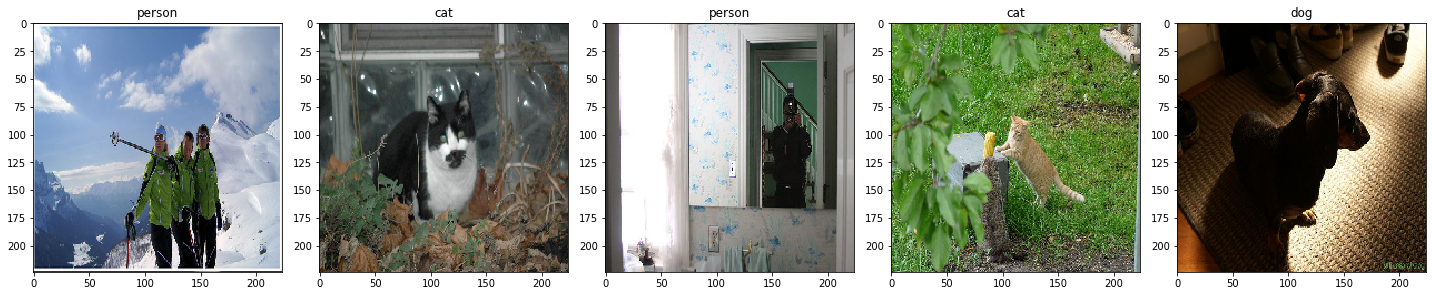

In [11]:
plotImages(sample_training_images[:5], labels[:5])

### Create "Callbacks" for Tensorboard monitor 

In [12]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 12),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'COCO_'+dateTime+'_model.h5'), monitor = 'val_loss', save_best_only = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### REGOLARIZZAZIONE

In [13]:
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)

reg.__dict__

{'l1': array(0., dtype=float32), 'l2': array(0., dtype=float32)}

## Create the model

The model consists of ... VGG16

In [14]:
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling='max')

for layer in base_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, reg)
          #print(layer.kernel_regularizer)


base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
model = Sequential()
model.add(Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output))

model.add(Conv2D(1024, 3, activation = 'relu', kernel_regularizer=reg))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(class_dict), activation="softmax"))

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

opt.__dict__

{'_use_locking': True,
 '_name': 'Adam',
 '_hyper': {'learning_rate': 0.0001,
  'decay': 0.0,
  'beta_1': 0.9,
  'beta_2': 0.999},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 0.0,
 '_hypers_created': False,
 'epsilon': 1e-08,
 'amsgrad': False,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 14, 14, 512)       14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 12, 1024)      4719616   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 19,438,404
Trainable params: 4,723,716
Non-trainable params: 14,714,688
_________________________________________________________________


### Train the model

Use the 'fit' (`fit_generator`) method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    #class_weight=class_weight
)
for key in history.history:
    print(key)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 60 steps, validate for 32 steps
Epoch 1/200
60/60 [==============================] - 80s 1s/step - loss: 1.1709 - accuracy: 0.4937 - val_loss: 1.0155 - val_accuracy: 0.5820
Epoch 2/200
60/60 [==============================] - 59s 976ms/step - loss: 0.8781 - accuracy: 0.6582 - val_loss: 0.9090 - val_accuracy: 0.6289
Epoch 3/200
60/60 [==============================] - 59s 976ms/step - loss: 0.7795 - accuracy: 0.6772 - val_loss: 0.8124 - val_accuracy: 0.6660
Epoch 4/200
60/60 [==============================] - 58s 971ms/step - loss: 0.6719 - accuracy: 0.7405 - val_loss: 0.8346 - val_accuracy: 0.6504
Epoch 5/200
60/60 [==============================] - 59s 976ms/step - loss: 0.6285 - accuracy: 0.7690 - val_loss: 0.8032 - val_accuracy: 0.6758
Epoch 6/200
60/60 [==============================] - 59s 976ms/step - loss: 0.5878 - accuracy: 0.7574 - val_loss: 0.7508 - val_accuracy: 0.6934
Epoch 7/200
60/60 [============================

### Visualize training results

Now visualize the results after training the network.

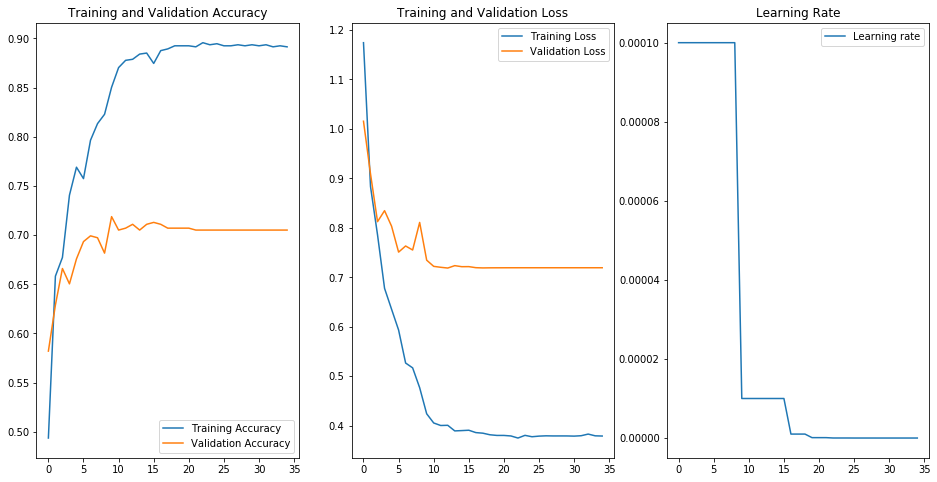

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.legend(loc='upper right')
plt.title('Learning Rate')
plt.show()

## Overfitting

## Data augmentation

In [20]:
LogsDir = os.path.join(PATH_log, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 

callbacks_list_2 = [
    tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 12),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'COCO2_'+dateTime+'_model_2.h5'), monitor = 'val_loss', save_best_only = True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### COSTANTI

In [21]:
L1 = 0.
L2 = 0.

Adam = tf.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

opt=Adam

### Augment and visualize data

In [22]:
def std_set_2(image):
    image = np.array(image)
    image -= IMAGE_MEAN
    #image /= IMAGE_STD
    return image

In [23]:
image_gen_train = ImageDataGenerator(
                    preprocessing_function = std_set_2,
                    rescale=1./255,
                    # rotation_range=45,
                    # width_shift_range=.15,
                    # height_shift_range=.15,
                    horizontal_flip=True,
                    # zoom_range=0.4,
                    brightness_range=[0.3, 1.0],
                    validation_split=0.4                    
                    )

In [24]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                     subset='training')

Found 888 images belonging to 4 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [25]:
val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                 directory=train_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical',
                                                 subset='validation')

Found 592 images belonging to 4 classes.


#### REGOLARIZZAZIONE

In [26]:
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)

reg.__dict__

{'l1': array(0., dtype=float32), 'l2': array(0., dtype=float32)}

## Dropout

## Creating a new network with Dropouts

In [27]:
from tensorflow.keras.layers import Dropout

model_new = Sequential()
model_new.add(Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output))
#model_new.add(Dropout(0.2))
model_new.add(Conv2D(1024, 3, activation = 'relu', kernel_regularizer=reg))
#model_new.add(Dropout(0.2))
model_new.add(GlobalAveragePooling2D())
model_new.add(Dense(len(class_dict), activation="softmax"))

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 14, 14, 512)       14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 1024)      4719616   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 19,438,404
Trainable params: 4,723,716
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [28]:
model_new.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

opt.__dict__

{'_use_locking': True,
 '_name': 'Adam',
 '_hyper': {'learning_rate': 0.0001,
  'decay': 0.0,
  'beta_1': 0.9,
  'beta_2': 0.999},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 0.0,
 '_hypers_created': False,
 'epsilon': 1e-08,
 'amsgrad': False,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [29]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list_2,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    class_weight=class_weight
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 55 steps, validate for 37 steps
Epoch 1/200
55/55 [==============================] - 68s 1s/step - loss: 1.3745 - accuracy: 0.4255 - val_loss: 1.2342 - val_accuracy: 0.4899
Epoch 2/200
55/55 [==============================] - 59s 1s/step - loss: 1.1828 - accuracy: 0.5092 - val_loss: 1.1230 - val_accuracy: 0.5220
Epoch 3/200
55/55 [==============================] - 59s 1s/step - loss: 1.0374 - accuracy: 0.5917 - val_loss: 1.0549 - val_accuracy: 0.5895
Epoch 4/200
55/55 [==============================] - 59s 1s/step - loss: 0.9643 - accuracy: 0.6158 - val_loss: 1.0059 - val_accuracy: 0.5811
Epoch 5/200
55/55 [==============================] - 58s 1s/step - loss: 0.9088 - accuracy: 0.6514 - val_loss: 1.0414 - val_accuracy: 0.5811
Epoch 6/200
55/55 [==============================] - 59s 1s/step - loss: 0.8757 - accuracy: 0.6560 - val_loss: 0.9916 - val_accuracy: 0.6132
Epoch 7/200
55/55 [==============================] - 58s 1s/st

### Visualize the model

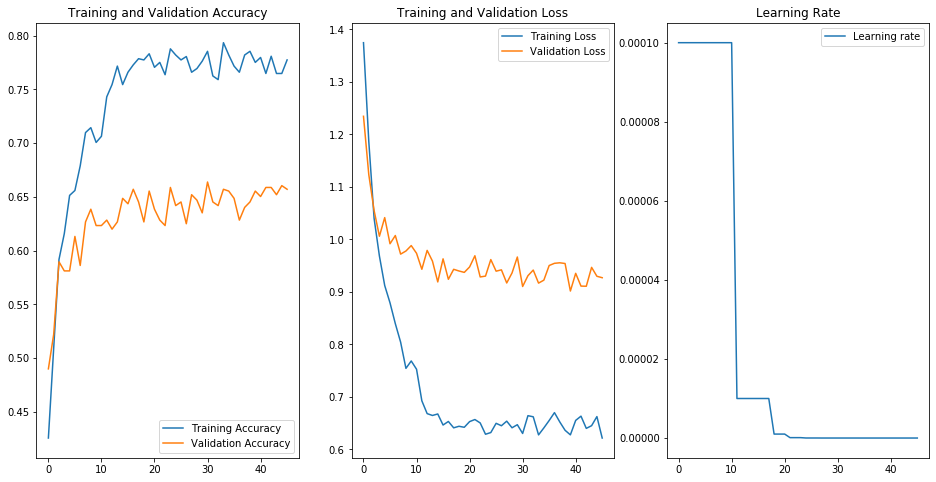

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.legend(loc='upper right')
plt.title('Learning Rate')
plt.show()